# Decision Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Decision Tree Regression

In [2]:
df = pd.read_csv('../data/Lab4/study_score.csv')
df1 = df.drop(columns="Pass", axis=1)
df1

,StudyHours,SleepHours,CoffeeCups,Score
0,1,9,0,3
1,2,8,1,5
2,3,7,1,8
3,4,7,2,12
4,5,6,2,15
5,6,6,3,14
6,7,5,3,10
7,8,5,4,7
8,9,4,4,4
9,10,4,5,2


In [3]:
feature = "StudyHours"
target = "Score"
df1 = df1[[feature, target]].copy()
df1

,StudyHours,Score
0,1,3
1,2,5
2,3,8
3,4,12
4,5,15
5,6,14
6,7,10
7,8,7
8,9,4
9,10,2


In [4]:
df1.sort_values(by=feature, inplace=True)
df1

,StudyHours,Score
0,1,3
1,2,5
2,3,8
3,4,12
4,5,15
5,6,14
6,7,10
7,8,7
8,9,4
9,10,2


Text(0, 0.5, 'Score')

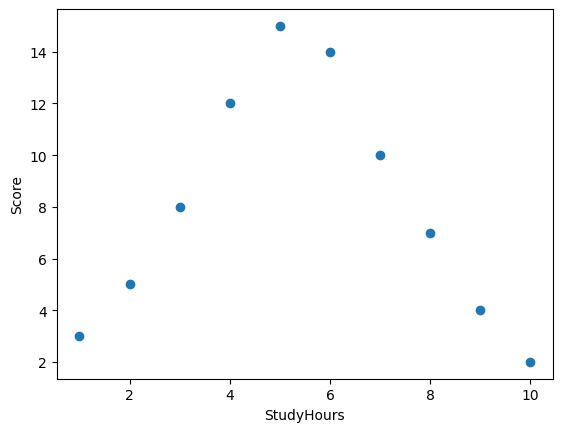

In [5]:
plt.scatter(df1[feature], df1[target])
plt.xlabel(feature)
plt.ylabel(target)

In [6]:
# Calculate the candidate thresholds
sorted_features = df[feature].sort_values()
unique_vals = np.unique(sorted_features)
thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

print(f"Threshold for the feature {feature}: {thresholds}")

Threshold for the feature StudyHours: [1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


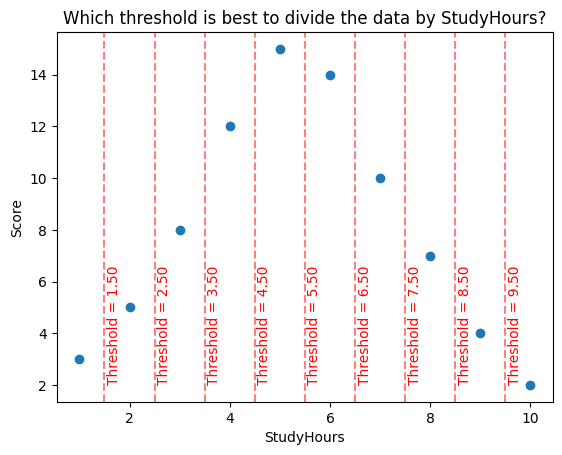

In [7]:
# Plotting the thresholds on the scatter plot
plt.scatter(df1[feature], df1[target])
for thresh in thresholds:
    plt.axvline(x=thresh, color='red', linestyle='--', alpha=0.5)
    plt.text(
        thresh + 0.05,
        df1[target].min(),
        f'Threshold = {thresh:.2f}',
        rotation=90,
        verticalalignment='bottom',
        color='red'
    )
plt.xlabel(feature)
plt.ylabel(target)
plt.title(f'Which threshold is best to divide the data by {feature}?')
plt.show()

In [8]:
# Compute mean target values for left and right splits
mean_left = []
mean_right = []

for thresh in thresholds:
    left_split = df1[df1[feature] <= thresh][target]
    right_split = df1[df1[feature] > thresh][target]

    mean_left.append(left_split.mean())
    mean_right.append(right_split.mean())

threshold_df = pd.DataFrame({
    "thresholds": thresholds,
    "mean_left": mean_left,
    "mean_right": mean_right,
})
threshold_df

,thresholds,mean_left,mean_right
0,1.5,3.000000,8.555556
1,2.5,4.000000,9.000000
2,3.5,5.333333,9.142857
3,4.5,7.000000,8.666667
4,5.5,8.600000,7.400000
5,6.5,9.500000,5.750000
6,7.5,9.571429,4.333333
7,8.5,9.250000,3.000000
8,9.5,8.666667,2.000000


In [9]:
# Compute variance (impurities) for each threshold
N = df1.shape[0]
var_thresholds = []

for i, row in threshold_df.iterrows():
    threshold = row.thresholds
    ml = row.mean_left
    mr = row.mean_right

    left_arr = df1[df1[feature] <= threshold][target].values
    right_arr = df1[df1[feature] > threshold][target].values

    var_left = ((left_arr - ml) ** 2).mean() if len(left_arr) > 0 else 0
    var_right = ((right_arr - mr) ** 2).mean() if len(right_arr) > 0 else 0

    N_left = left_arr.shape[0]
    N_right = right_arr.shape[0]

    var_threshold = var_left * (N_left/N) + var_right * (N_right/N)
    var_thresholds.append(var_threshold)

    print(f"Threshold={threshold}, var={var_threshold}")


Threshold=1.5, var=16.422222222222224
Threshold=2.5, var=15.2
Threshold=3.5, var=16.152380952380952
Threshold=4.5, var=18.533333333333335
Threshold=5.5, var=18.840000000000003
Threshold=6.5, var=15.825000000000001
Threshold=7.5, var=13.438095238095237
Threshold=8.5, var=12.95
Threshold=9.5, var=15.200000000000001


In [10]:
# The best threshold for this feature the least variance (impurities)
min_var_idx = np.argmin(var_thresholds)
best_threshold = thresholds[min_var_idx]
best_var = var_thresholds[min_var_idx]

print(f"Best threshold for {feature} is {best_threshold} with variance = {best_var}")

Best threshold for StudyHours is 8.5 with variance = 12.95


In [11]:
# Make prediction based on the best threshold for a new value of this feature
new_feature = 12
if new_feature <= best_threshold:
    prediction = threshold_df.loc[min_var_idx, 'mean_left']
else:
    prediction = threshold_df.loc[min_var_idx, 'mean_right']

print(f"Predicted {target} for {feature}={new_feature} is {prediction}")

Predicted Score for StudyHours=12 is 3.0


In [12]:
def mse(y):
    if len(y) == 0:
        return 0
    mean_y = y.mean()
    return ((y - mean_y) ** 2).mean()

def find_best_threshold_for_one_feature(df, feature, target):
    df1 = df[[feature, target]].copy()
    df1.sort_values(by=feature, inplace=True)

    x = df1[feature].values
    y = df1[target].values
    N = len(df1)

    # Compute unique sorted feature values
    unique_vals = np.unique(x)
    if unique_vals.size < 2:
        return None, np.inf
    thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

    best_threshold = None
    best_mse = np.inf

    # Compute MSE for each threshold
    for thresh in thresholds:
        left_mask = x <= thresh
        right_mask = ~left_mask

        y_left = y[left_mask]
        y_right = y[right_mask]

        # Skip degenerate splits
        if len(y_left) == 0 or len(y_right) == 0:
            continue

        ml = y_left.mean()
        mr = y_right.mean()

        # Variances (MSE impurity inside each side)
        var_left = mse(y_left)
        var_right = mse(y_right)

        N_left = len(y_left)
        N_right = len(y_right)

        # Weighted variance after split
        weighted_var = var_left * (N_left / N) + var_right * (N_right / N)

        if weighted_var < best_mse:
            best_mse = weighted_var
            best_threshold = thresh

    return best_threshold, best_mse

In [13]:
checking_feature = "SleepHours"
best_threshold, best_mse = find_best_threshold_for_one_feature(
    df=df,
    feature=checking_feature,
    target=target
)
print(f"Best threshold for feature {checking_feature} is {best_threshold}, Best Var: {best_mse}")

Best threshold for feature SleepHours is 4.5, Best Var: 12.95


In [14]:
# Select the root feature with the lowest MSE among candidates
candidate_features = ["StudyHours", "SleepHours", "CoffeeCups"]

def find_best_feature(df, candidate_features, target):
    best_feature = None
    best_threshold = None
    best_mse = np.inf

    for feature in candidate_features:
        threshold, mse = find_best_threshold_for_one_feature(df, feature, target)
        print(f"Fearure={feature},Threshold={threshold}, var={mse}")

    if mse < best_mse:
        best_mse = mse
        best_threshold = threshold
        best_feature = feature

    return best_feature, best_threshold, best_mse

best_feature, best_threshold, best_mse = find_best_feature(df, candidate_features, target)
print(f"Selected Root Feature: {best_feature}, Threshold: {best_threshold}, Var: {best_mse}")

Fearure=StudyHours,Threshold=8.5, var=12.95
Fearure=SleepHours,Threshold=4.5, var=12.95
Fearure=CoffeeCups,Threshold=3.5, var=13.438095238095237
Selected Root Feature: CoffeeCups, Threshold: 3.5, Var: 13.438095238095237


In [15]:
left_df = df[df[best_feature] <= best_threshold]
right_df = df[df[best_feature] > best_threshold]
left_df, right_df

(   StudyHours  SleepHours  CoffeeCups  Score  Pass
 0           1           9           0      3     0
 1           2           8           1      5     0
 2           3           7           1      8     1
 3           4           7           2     12     1
 4           5           6           2     15     1
 5           6           6           3     14     1
 6           7           5           3     10     1,
    StudyHours  SleepHours  CoffeeCups  Score  Pass
 7           8           5           4      7     0
 8           9           4           4      4     0
 9          10           4           5      2     0)

In [16]:
best_feature2, best_threshold2, best_mse2 = find_best_feature(df, candidate_features, target)
best_feature2, best_threshold2

Fearure=StudyHours,Threshold=8.5, var=12.95
Fearure=SleepHours,Threshold=4.5, var=12.95
Fearure=CoffeeCups,Threshold=3.5, var=13.438095238095237


('CoffeeCups', np.float64(3.5))

In [17]:
for feature in candidate_features:
    thresh, mse_after = find_best_threshold_for_one_feature(df, feature, "Score")
    print(f"{feature}: threshold={thresh}, mse_after={mse_after}")

StudyHours: threshold=8.5, mse_after=12.95
SleepHours: threshold=4.5, mse_after=12.95
CoffeeCups: threshold=3.5, mse_after=13.438095238095237


In [18]:
def build_tree(df, candidate_features, target, min_samples=5, depth=0, max_depth=3):
    # Stopping criteria
    if len(df) < min_samples or depth >= max_depth:
        return {
            "type": "leaf",
            "prediction": df[target].mean()
        }

    # Find the best feature and threshold to split on
    best_feature, best_threshold, best_mse = find_best_feature(
        df=df,
        candidate_features=candidate_features,
        target=target)

    if best_feature is None:
        return {
            "type": "leaf",
            "prediction": df[target].mean()
        }

    left_df = df[df[best_feature] <= best_threshold]
    right_df = df[df[best_feature] > best_threshold]

    left_subtree = build_tree(
        df=left_df,
        candidate_features=candidate_features,
        target=target,
        min_samples=min_samples,
        depth=depth + 1,
        max_depth=max_depth
    )
    right_subtree = build_tree(
        df=right_df,
        candidate_features=candidate_features,
        target=target,
        min_samples=min_samples,
        depth=depth + 1,
        max_depth=max_depth
    )

    return {
        "type": "node",
        "feature": best_feature,
        "threshold": best_threshold,
        "left": left_subtree,
        "right": right_subtree
    }

In [19]:
df_reg = df.drop(columns="Pass", axis=1)
df_reg

,StudyHours,SleepHours,CoffeeCups,Score
0,1,9,0,3
1,2,8,1,5
2,3,7,1,8
3,4,7,2,12
4,5,6,2,15
5,6,6,3,14
6,7,5,3,10
7,8,5,4,7
8,9,4,4,4
9,10,4,5,2


In [20]:
tree = build_tree(
    df=df_reg,
    candidate_features=['CoffeeCups', 'SleepHours', 'StudyHours'],
    target="Score")
tree

Fearure=CoffeeCups,Threshold=3.5, var=13.438095238095237
Fearure=SleepHours,Threshold=4.5, var=12.95
Fearure=StudyHours,Threshold=8.5, var=12.95
Fearure=CoffeeCups,Threshold=1.5, var=6.733333333333334
Fearure=SleepHours,Threshold=7.5, var=6.75
Fearure=StudyHours,Threshold=3.5, var=6.733333333333334
Fearure=CoffeeCups,Threshold=3.5, var=2.95
Fearure=SleepHours,Threshold=5.5, var=1.8333333333333335
Fearure=StudyHours,Threshold=6.5, var=1.8333333333333335


{'type': 'node',
 'feature': 'StudyHours',
 'threshold': np.float64(8.5),
 'left': {'type': 'node',
  'feature': 'StudyHours',
  'threshold': np.float64(3.5),
  'left': {'type': 'leaf', 'prediction': np.float64(5.333333333333333)},
  'right': {'type': 'node',
   'feature': 'StudyHours',
   'threshold': np.float64(6.5),
   'left': {'type': 'leaf', 'prediction': np.float64(13.666666666666666)},
   'right': {'type': 'leaf', 'prediction': np.float64(8.5)}}},
 'right': {'type': 'leaf', 'prediction': np.float64(3.0)}}

In [21]:
def predict(tree, sample):
    if tree["type"] == "leaf":
        return tree["prediction"]

    feature = tree["feature"]
    threshold = tree["threshold"]

    if sample[feature] <= threshold:
        return predict(tree["left"], sample)
    else:
        return predict(tree["right"], sample)

In [22]:
prediction = predict(tree, {"CoffeeCups": 3, "SleepHours": 6, "StudyHours": 10})
prediction

np.float64(3.0)

## 2. Decision Tree Classification (Classification Tree)

In [23]:
df = pd.read_csv("../data/Lab4/study_score.csv")
df = df.drop(columns="Score", axis=1)
df

,StudyHours,SleepHours,CoffeeCups,Pass
0,1,9,0,0
1,2,8,1,0
2,3,7,1,1
3,4,7,2,1
4,5,6,2,1
5,6,6,3,1
6,7,5,3,1
7,8,5,4,0
8,9,4,4,0
9,10,4,5,0


In [24]:
feature = "StudyHours"
target = "Pass"
df2 = df[[feature, target]].copy()
df2

,StudyHours,Pass
0,1,0
1,2,0
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,0
8,9,0
9,10,0


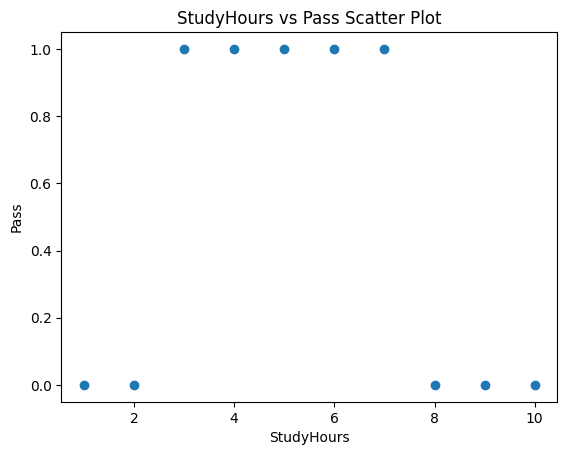

In [25]:
plt.scatter(df2[feature], df2[target])
plt.xlabel(feature)
plt.ylabel(target)
plt.title(f'{feature} vs {target} Scatter Plot')
plt.show()

In [26]:
def gini_impurity(y):
    if len(y) == 0:
        return 0

    proportions = y.value_counts(normalize=True)
    return 1 - np.sum(proportions ** 2)

In [27]:
def find_best_threshold_classification(df, feature, target):
    df1 = df[[feature, target]].sort_values(by=feature)
    X = df1[feature].values
    y = df1[target]

    unique_vals = np.unique(X)

    if len(unique_vals) == 1:
        return None, np.inf

    candidate_thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

    best_threshold = None
    best_gini = np.inf

    for threshold in candidate_thresholds:
        left_mask = X <= threshold
        right_mask = X > threshold

        left_gini = gini_impurity(y[left_mask])
        right_gini = gini_impurity(y[right_mask])

        n = len(df1)
        nl = left_mask.sum()
        nr = right_mask.sum()

        weighted_gini = (nl/n) * left_gini + (nr/n) * right_gini

        if weighted_gini < best_gini:
            best_gini = weighted_gini
            best_threshold = threshold

    return best_threshold, best_gini

In [28]:
find_best_threshold_classification(df, "CoffeeCups", target)

(np.float64(3.5), np.float64(0.2857142857142857))

In [29]:
def find_best_feature_classification(df, candidate_features, target):
    best_feature = None
    best_threshold = None
    best_gini = np.inf

    for feature in candidate_features:
        threshold, gini_value = find_best_threshold_classification(df, feature, target)

        if threshold is None:
            continue

        if gini_value < best_gini:
            best_gini = gini_value
            best_threshold = threshold
            best_feature = feature

    return best_feature, best_threshold, best_gini

In [30]:
def build_tree_classification(df, candidate_features, target,
                              min_samples=5, depth=0, max_depth=3):
    # Stopping criteria
    if len(df) < min_samples or depth >= max_depth:
        return {
            "type": "leaf",
            "prediction": df[target].mode()[0] # majority class
        }

    best_feature, best_threshold, best_gini = find_best_feature_classification(
        df=df,
        candidate_features=candidate_features,
        target=target
    )

    if best_feature is None:
        return {
            "type": "leaf",
            "prediction": df[target].mode()[0]
        }

    print(df)
    left_df = df[df[best_feature] <= best_threshold]
    print(f"Left df: {left_df}")
    right_df = df[df[best_feature] > best_threshold]
    print(f"Right df: {right_df}")

    left_subtree = build_tree_classification(
        df=left_df,
        candidate_features=candidate_features,
        target=target,
        min_samples=min_samples,
        depth=depth + 1,
        max_depth=max_depth
    )

    right_subtree = build_tree_classification(
        df=right_df,
        candidate_features=candidate_features,
        target=target,
        min_samples=min_samples,
        depth=depth + 1,
        max_depth=max_depth
    )

    return {
        "type": "node",
        "feature": best_feature,
        "threshold": best_threshold,
        "left": left_subtree,
        "right": right_subtree
    }

In [31]:
classification_tree = build_tree_classification(
    df=df,
    candidate_features=[feature],
    target=target
)
classification_tree

   StudyHours  SleepHours  CoffeeCups  Pass
0           1           9           0     0
1           2           8           1     0
2           3           7           1     1
3           4           7           2     1
4           5           6           2     1
5           6           6           3     1
6           7           5           3     1
7           8           5           4     0
8           9           4           4     0
9          10           4           5     0
Left df:    StudyHours  SleepHours  CoffeeCups  Pass
0           1           9           0     0
1           2           8           1     0
2           3           7           1     1
3           4           7           2     1
4           5           6           2     1
5           6           6           3     1
6           7           5           3     1
Right df:    StudyHours  SleepHours  CoffeeCups  Pass
7           8           5           4     0
8           9           4           4     0
9          10

{'type': 'node',
 'feature': 'StudyHours',
 'threshold': np.float64(7.5),
 'left': {'type': 'node',
  'feature': 'StudyHours',
  'threshold': np.float64(2.5),
  'left': {'type': 'leaf', 'prediction': np.int64(0)},
  'right': {'type': 'node',
   'feature': 'StudyHours',
   'threshold': np.float64(3.5),
   'left': {'type': 'leaf', 'prediction': np.int64(1)},
   'right': {'type': 'leaf', 'prediction': np.int64(1)}}},
 'right': {'type': 'leaf', 'prediction': np.int64(0)}}

In [32]:
def predict_classification(tree, sample):
    if tree["type"] == "leaf":
        return tree["prediction"]

    feature = tree["feature"]
    threshold = tree["threshold"]

    if sample[feature] <= threshold:
        return predict_classification(tree["left"], sample)
    else:
        return predict_classification(tree["right"], sample)

In [33]:
predict_classification(
    tree=classification_tree,
    sample={"CoffeeCups": 3, "SleepHours": 7, "StudyHours": 10}
)

np.int64(0)

## 3. Using `sklearn`

In [34]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

In [35]:
reg_tree = DecisionTreeRegressor(
    criterion="squared_error",
    max_depth=3,
    min_samples_split=5,
    random_state=42,
)

In [36]:
df = pd.read_csv("../data/Lab4/study_score.csv")
df_reg = df.drop(columns="Pass", axis=1)
df_clf = df.drop(columns="Score", axis=1)
df_reg, df_clf

(   StudyHours  SleepHours  CoffeeCups  Score
 0           1           9           0      3
 1           2           8           1      5
 2           3           7           1      8
 3           4           7           2     12
 4           5           6           2     15
 5           6           6           3     14
 6           7           5           3     10
 7           8           5           4      7
 8           9           4           4      4
 9          10           4           5      2,
    StudyHours  SleepHours  CoffeeCups  Pass
 0           1           9           0     0
 1           2           8           1     0
 2           3           7           1     1
 3           4           7           2     1
 4           5           6           2     1
 5           6           6           3     1
 6           7           5           3     1
 7           8           5           4     0
 8           9           4           4     0
 9          10           4           5     

In [37]:
features = ['StudyHours', 'SleepHours', 'CoffeeCups']
X_reg = df_reg[features].to_numpy()
y_reg = df[target].to_numpy()
X_reg, y_reg

(array([[ 1,  9,  0],
        [ 2,  8,  1],
        [ 3,  7,  1],
        [ 4,  7,  2],
        [ 5,  6,  2],
        [ 6,  6,  3],
        [ 7,  5,  3],
        [ 8,  5,  4],
        [ 9,  4,  4],
        [10,  4,  5]]),
 array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0]))

In [38]:
reg_tree.fit(X_reg, y_reg)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


[Text(0.6, 0.8333333333333334, 'CoffeeCups <= 3.5\nsquared_error = 0.25\nsamples = 10\nvalue = 0.5'),
 Text(0.4, 0.5, 'SleepHours <= 7.5\nsquared_error = 0.204\nsamples = 7\nvalue = 0.714'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 1.0'),
 Text(0.6, 0.16666666666666666, 'squared_error = 0.0\nsamples = 2\nvalue = 0.0'),
 Text(0.8, 0.5, 'squared_error = 0.0\nsamples = 3\nvalue = 0.0'),
 Text(0.7, 0.6666666666666667, '  False')]

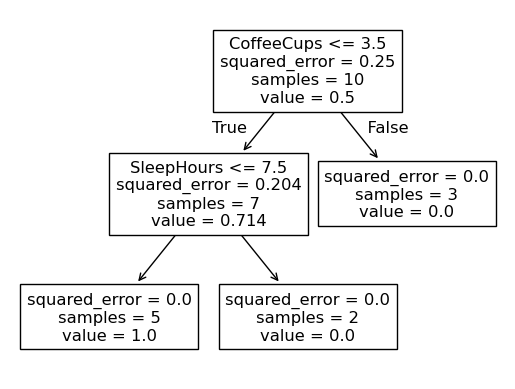

In [39]:
ax = plot_tree(reg_tree, feature_names=df_reg.columns)
ax


In [40]:
reg_tree.predict(np.array([3,6,10]).reshape(1,3))

array([0.])

In [41]:
cls_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_split=5,
    random_state=42,
)
cls_tree.fit(df_clf[features], df_clf[target])
cls_tree.predict(np.array([3,6,10]).reshape(1,3))

/Users/khueluu/Documents/Projects/NSU_ML/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([0])

[Text(0.6, 0.8333333333333334, 'CoffeeCups <= 3.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.4, 0.5, 'SleepHours <= 7.5\ngini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.7, 0.6666666666666667, '  False')]

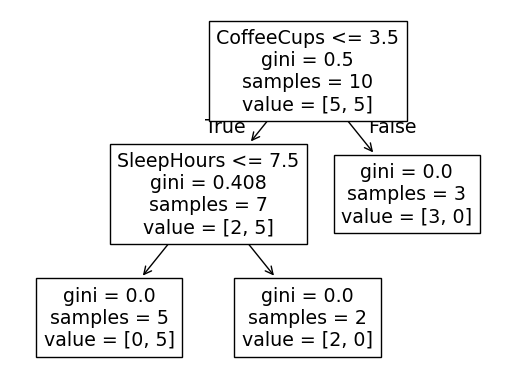

In [42]:
plot_tree(cls_tree, feature_names=df_clf.columns)